In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read in all the words
words = open('../names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [42]:
# INITIALISE (MLP revisited)
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) # Kaiming init (He et al., 2015) (5/3 is the gain specfic to Tanh)
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01 # can be good to have a little bit of entropy in the biases
# ^ b1 is not needed because we will use BatchNorm directly after it (so it would get subtracted out anyway)
# ...effectively, the batch norm bias (bnbias) will be the bias for the hidden layer instead
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # want W2 to be small at initialisation
b2 = torch.randn(vocab_size,                      generator=g) * 0 # initialise the bias to zero

# BatchNorm parameters (gain and bias are both learnable)
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12297


In [33]:
hpreact.shape # (batch_size, n_hidden)

torch.Size([32, 200])

In [34]:
hpreact.mean(dim=0, keepdim=True).shape

torch.Size([1, 200])

In [43]:
# same optimisation as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate/flatten the vectors
    # Linear layer
    hpreact = embcat @ W1 # + b1 # hidden layer pre-activations
    # BatchNorm Layer
    # ------------------------------------------------------------
    bnmeani = hpreact.mean(dim=0, keepdim=True)
    bnstdi = hpreact.std(dim=0, keepdim=True)
    hpreact = (hpreact - bnmeani) / bnstdi
    hpreact = hpreact * bngain + bnbias # scale and shift

    with torch.no_grad(): # the updating of these is "done on the side", we don't need to track gradients
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
        # note that this is also implemented in PyTorch's BatchNorm1d layer
    # ------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer activations
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
      p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


In [27]:
# NOTE: before scaling down W1 and b1...
# the tanh functions is being saturated
# it is squashing the input to the range [-1, 1], but the input range is currently much larger
# so, a lot of the input is being squashed to the same value
# in backpropagation when the output of tanh is -1 or 1, the gradient is 0
# meaning the backprop is effectively stopped

# after scaling down W1 and b1...
# the distribution looks much better

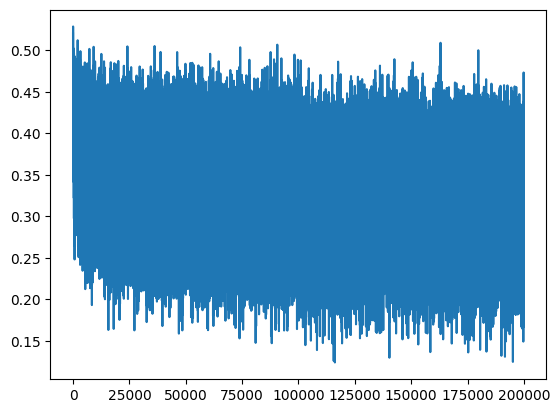

In [44]:
plt.plot(lossi)

In [45]:
# calibrate the batch norm at the end of training
# this is so that at test time, we don't need to pass in batches
# e.g. if we just want to forward pass one example, we don't want to have to calculate the mean and std of a batch of size 1

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean and std of the activations over the training set
    bnmean = hpreact.mean(dim=0, keepdim=True)
    bnstd = hpreact.std(dim=0, keepdim=True)

# this is no longer needed now that we are calculating running mean/std during training

In [48]:
# Evaluation on the train and dev sets

@torch.no_grad() # this decorator disables gradient tracking (which is usually done in anticipation of an eventual backward pass)
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  # hpreact = (hpreact - hpreact.mean(dim=0, keepdim=True)) / hpreact.std(dim=0, keepdim=True) # batch norm
  hpreact = (hpreact - bnmean_running) / bnstd_running
  hpreact = hpreact * bngain + bnbias # scale and shift
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.066591501235962
val 2.1050572395324707


### Loss Log

#### Original: 
train 2.12, val 2.17

#### Fix softmax and confidently wrong (by scaling down W2 and initialising b2 to 0): 
train 2.07, val 2.13

#### Fix tanh layer too saturated at init (by scaling down W1 and b1): 
train 2.04, val 2.10

### Use Kaiming Init:
train 2.04, val 2.10

### Add Batch Norm layer:
train 2.07, val 2.10

In [15]:
# Sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all "..."
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the content of the window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special end-of-word token, stop there
        if ix == 0:
            break

    print(''.join(itos[i] for i in out)) # decode and print generated word


mona.
mayah.
seel.
nihahla.
ren.
ruchadrael.
adeeroselin.
shy.
jenne.
elionna.
arleit.
kollyan.
noshuberlihiriel.
kendreth.
konnie.
conu.
zen.
dariyah.
faeha.
kayjahsh.
